# WeightWatcher DenseNet

https://calculationconsulting.com




### Key Idea in DenseNet 

Dense Connections: connect back to all previous Conv2d feature maps from all previous layers

https://www.jeremyjordan.me/convnet-architectures/#densenet

*"concatenating feature-maps learned by different layers increases variation in the input of subsequent layers and improves efficiency."*



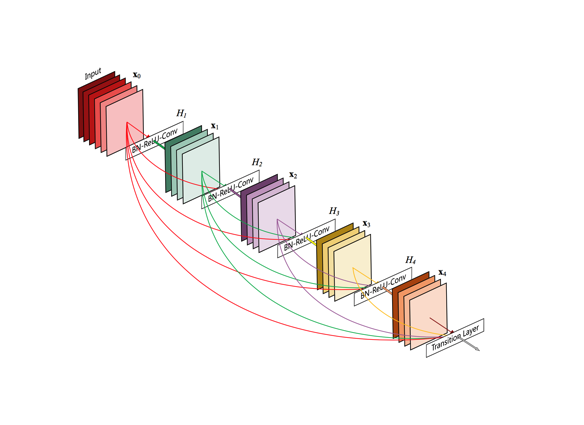

In [1]:
from IPython.display import Image
Image(filename='densenet.png',width=400)

## Summary of Results

A great example of where the $\hat{\alpha}$ does not correlated at all, but the new p-Norm metric does.



In [2]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import WeightWatcher

set custom Logging at WARN Level

In [4]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

import weightwatcher as ww
import torchvision.models as models

ww.__version__


Using TensorFlow backend.


'0.2.5'

###  Helper Notebook to make Plots


In [5]:
import import_ipynb
import ModelPlots as MP

importing Jupyter notebook from ModelPlots.ipynb


### Create all models now

In [6]:
series_name = 'DenseNet'
all_names = [ 'densenet121', 'densenet169', 'densenet201', 'densenet161']
colors = ['blue', 'green', 'teal', 'red']

In [7]:
all_models = []
all_models.append(models.densenet121(pretrained=True))
all_models.append(models.densenet161(pretrained=True))
all_models.append(models.densenet169(pretrained=True))
all_models.append(models.densenet201(pretrained=True))


### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html


<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-even"><td><p>Densenet-121</p></td>
<td><p>25.35</p></td>
<td><p>7.83</p></td>
</tr>
<tr class="row-odd"><td><p>Densenet-169</p></td>
<td><p>24.00</p></td>
<td><p>7.00</p></td>
</tr>
<tr class="row-even"><td><p>Densenet-201</p></td>
<td><p>22.80</p></td>
<td><p>6.43</p></td>
</tr>
<tr class="row-odd"><td><p>Densenet-161</p></td>
<td><p>22.35</p></td>
<td><p>6.20</p></td>
</tr>

</tbody>
</table>
</pre>

In [8]:
top1_errors= {
    
    "densenet121": 25.35,
    "densenet169": 24.00,
    "densenet201": 22.80,
    "densenet161": 22.35 

}

In [9]:
top5_errors= {
    
    "densenet121": 7.83,
    "densenet169": 7.00,
    "densenet201": 6.43,
    "densenet161": 6.20 

}

## Run WeightWatcher, collect summary and details (as dataframes) for all models

In [10]:
all_details = []
all_summaries = []
for im, name in enumerate(tqdm(all_names)):
    watcher = ww.WeightWatcher(model=all_models[im], logger=logger)
    results = watcher.analyze(alphas=True, softranks=True, spectralnorms=True, 
                              mp_fit=True, normalize=True, glorot_fix=True)

    summary =  watcher.get_summary()
    all_summaries.append(summary)
    details  = watcher.get_details(results=results)
    details.drop(columns=['slice', 'slice_count'], inplace=True)
    details.dropna(inplace=True)
    details['NxM'] = pd.to_numeric(details.N * details.M)

    all_details.append(details)

100%|██████████| 4/4 [06:59<00:00, 104.85s/it]


In [15]:
first_n_last_ids = [0, len(all_details)-1]

saving img/DenseNet_accs.png


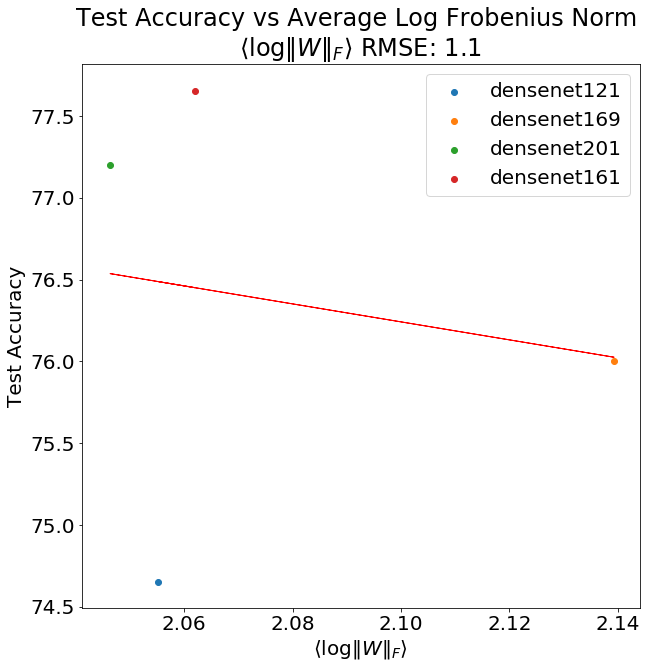

saving img/DenseNet_accs.png


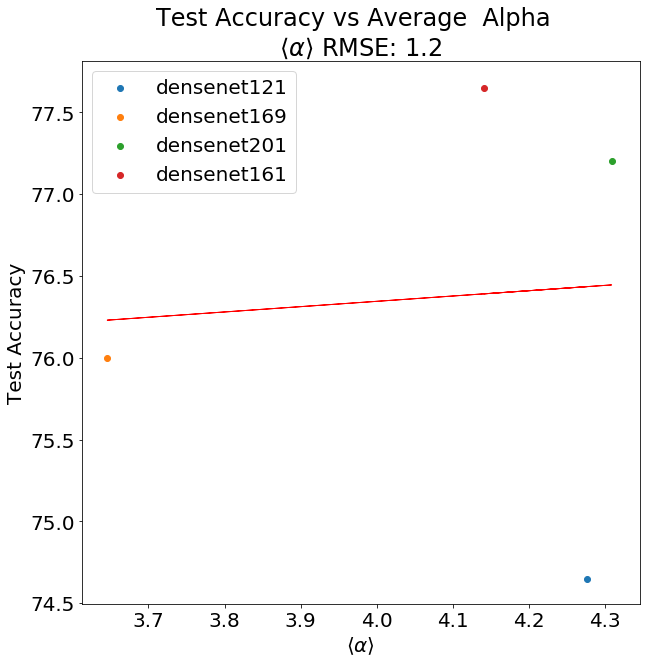

saving img/DenseNet_accs.png


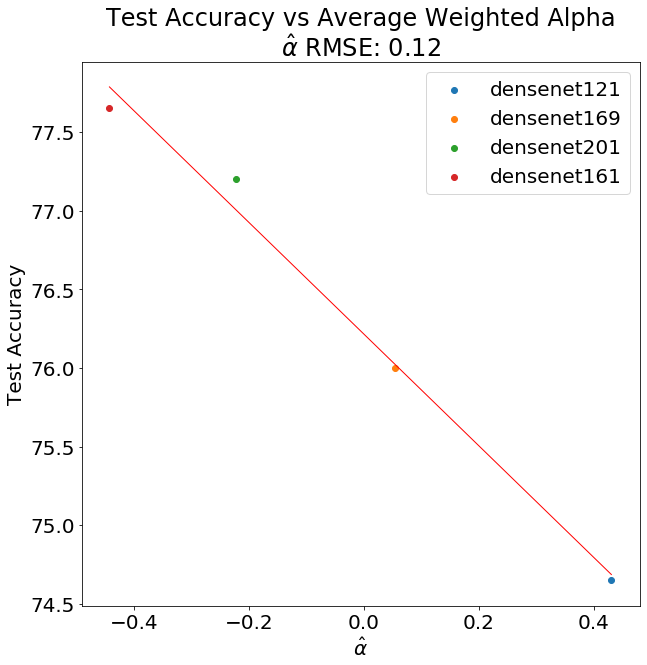

saving img/DenseNet_accs.png


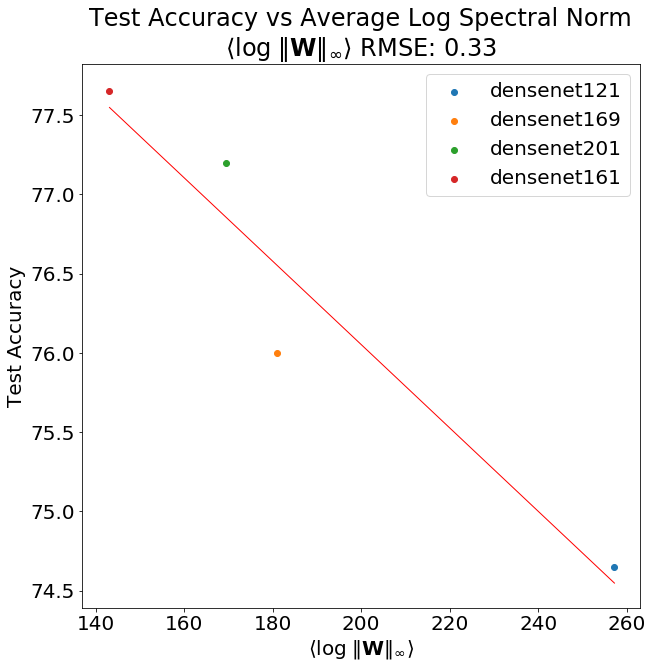

saving img/DenseNet_accs.png


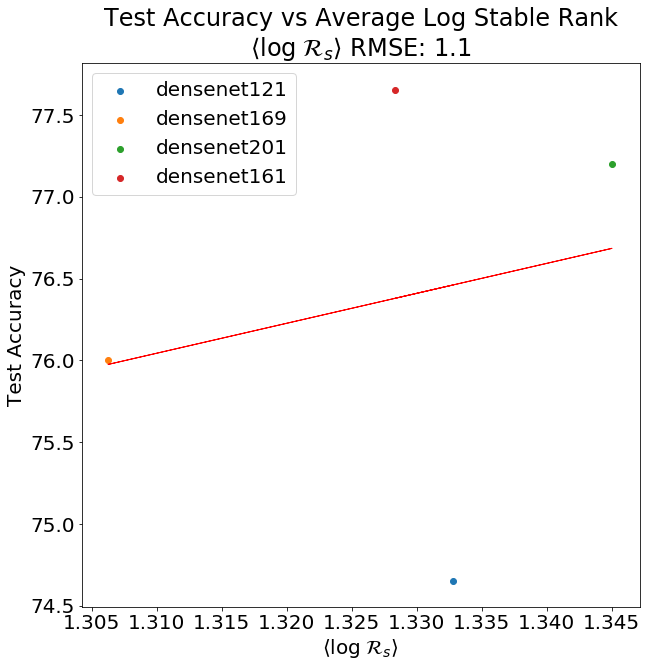

saving img/DenseNet_accs.png


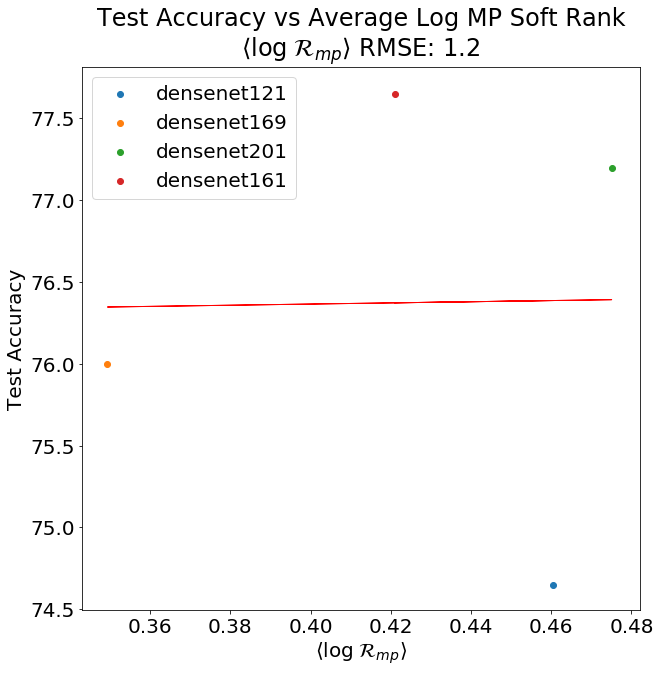

saving img/DenseNet_accs.png


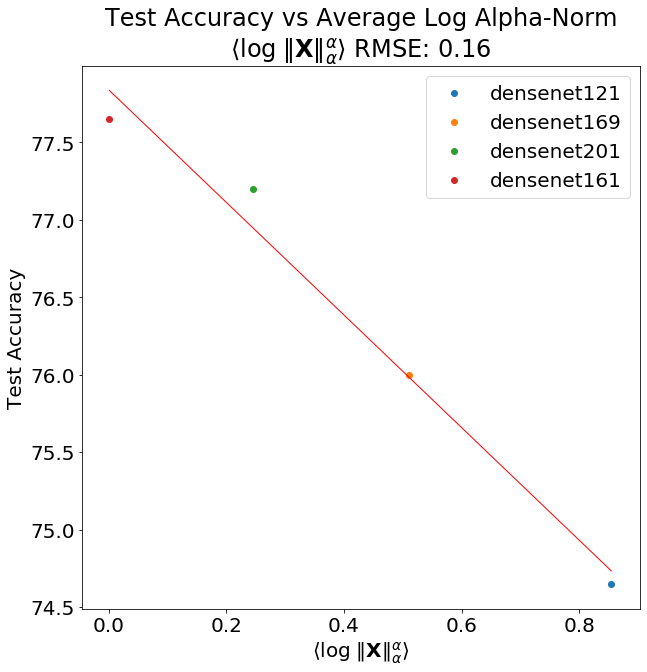

In [16]:
MP.plot_all_metrics_vs_test_accuracies( \
    series_name, all_names, colors, all_summaries, all_details, top1_errors)

saving img/DenseNet_all_hist.png


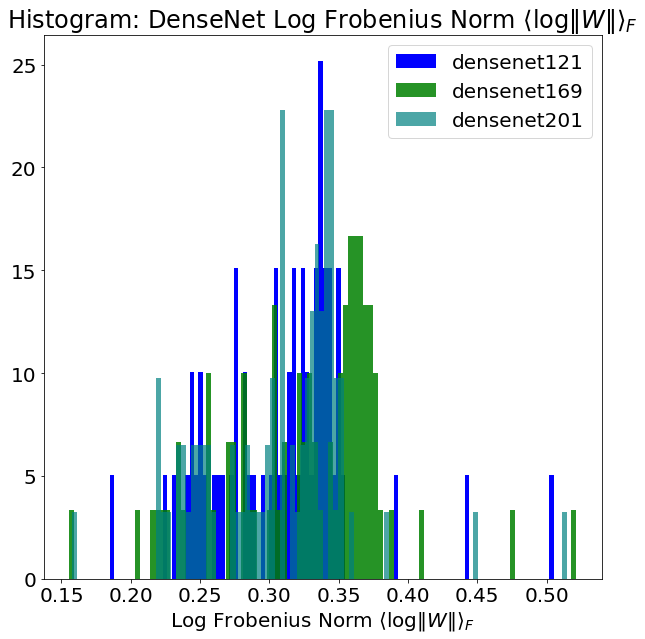

saving img/DenseNet_fnl_hist.png


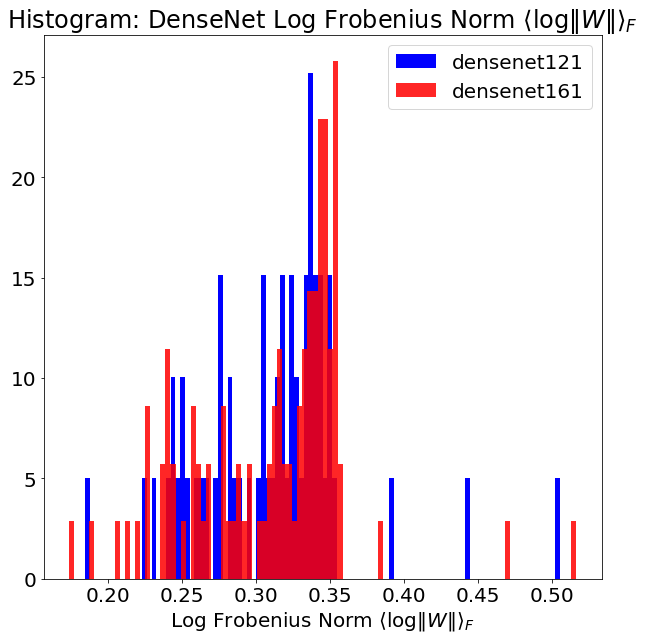

saving img/DenseNet_all_hist.png


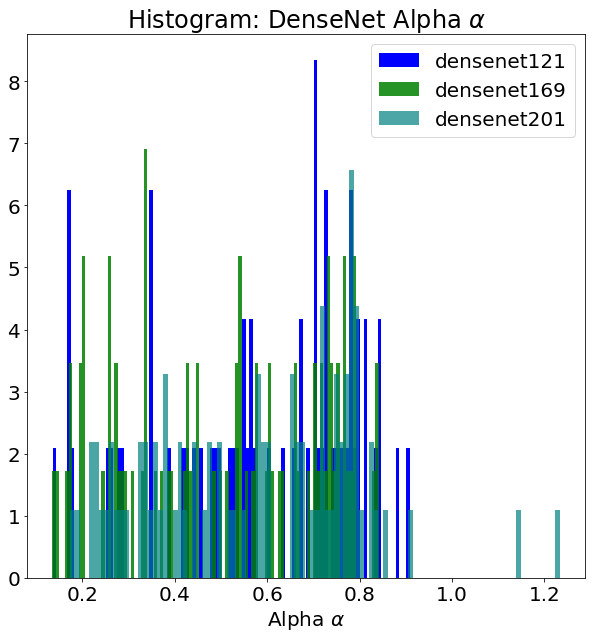

saving img/DenseNet_fnl_hist.png


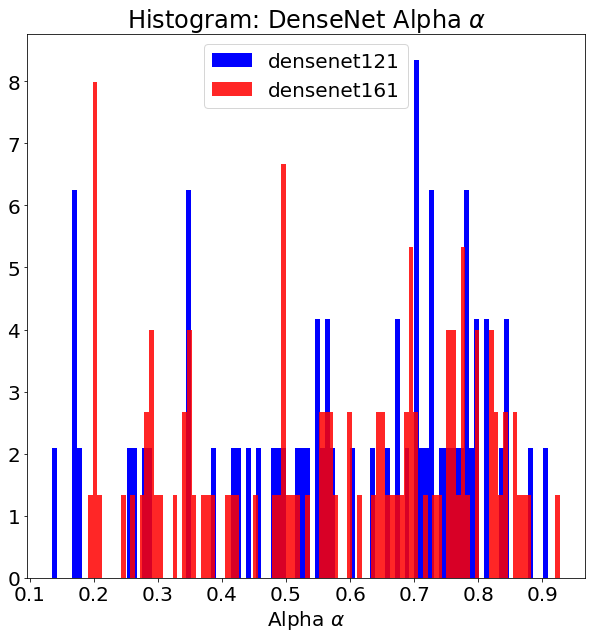

saving img/DenseNet_all_hist.png


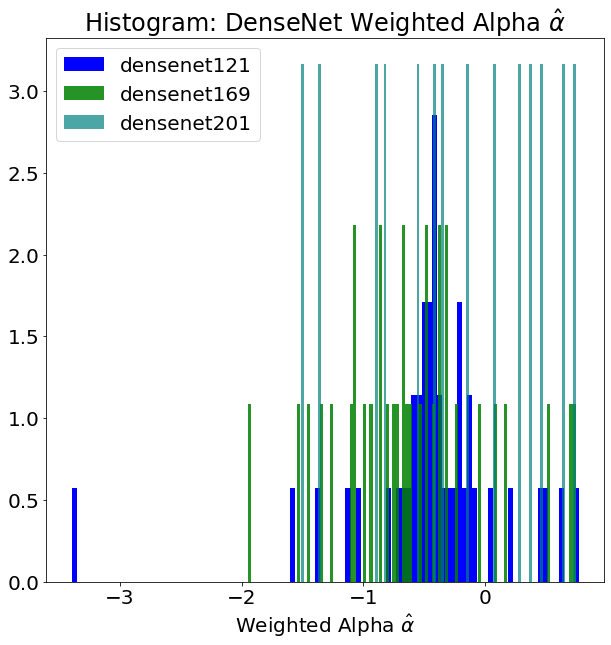

saving img/DenseNet_fnl_hist.png


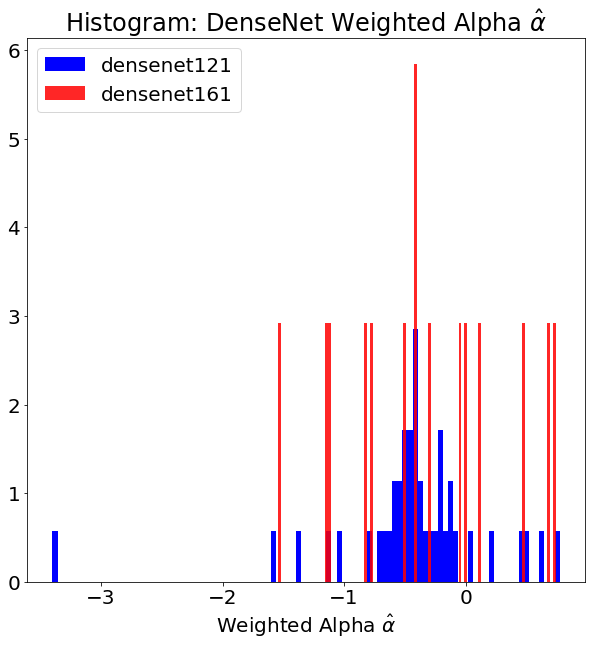

saving img/DenseNet_all_hist.png


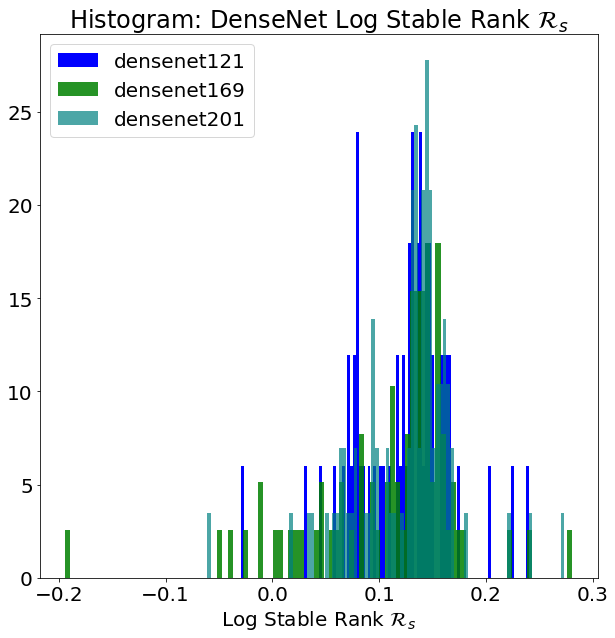

saving img/DenseNet_fnl_hist.png


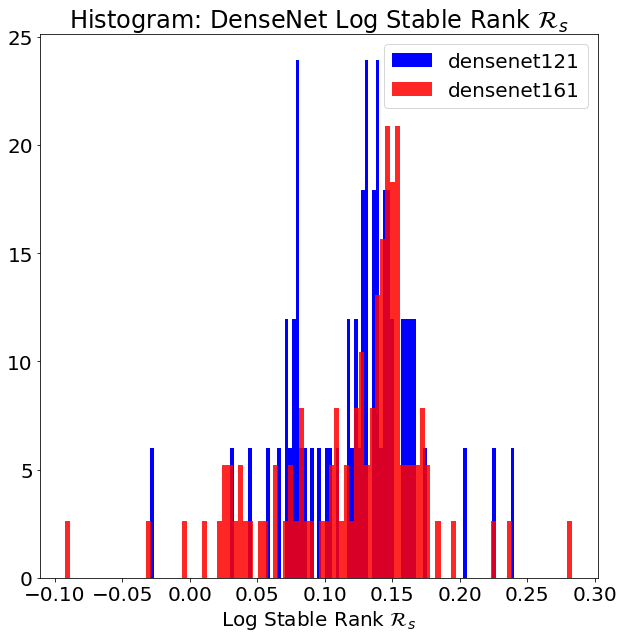

saving img/DenseNet_all_hist.png


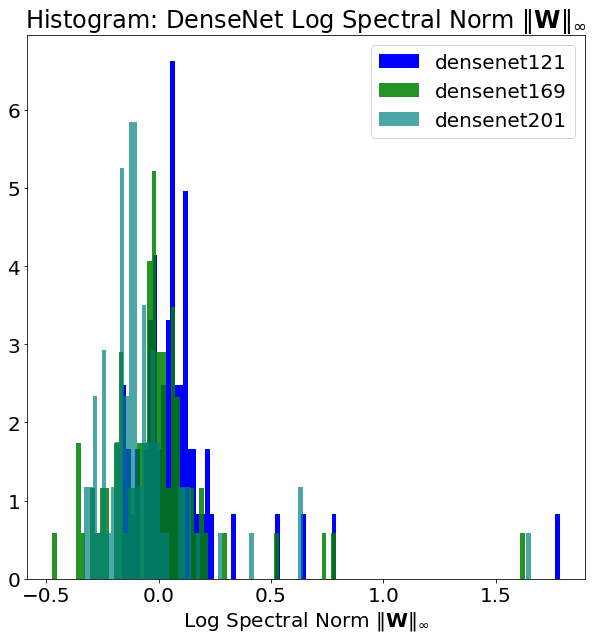

saving img/DenseNet_fnl_hist.png


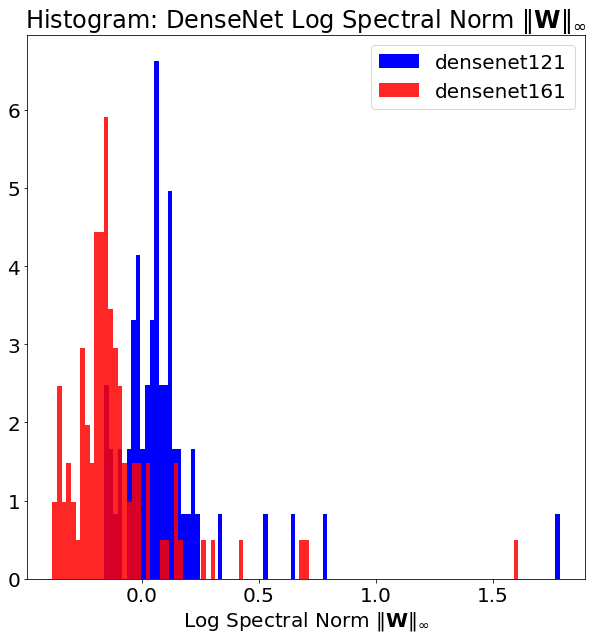

saving img/DenseNet_all_hist.png


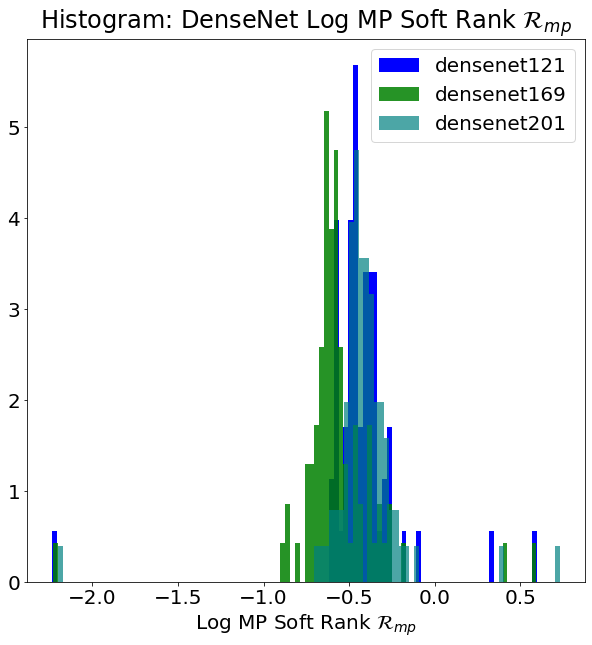

saving img/DenseNet_fnl_hist.png


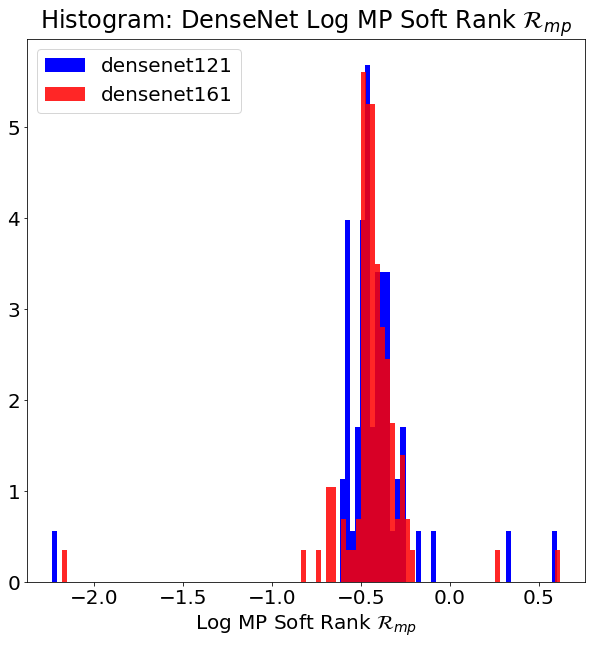

saving img/DenseNet_all_hist.png


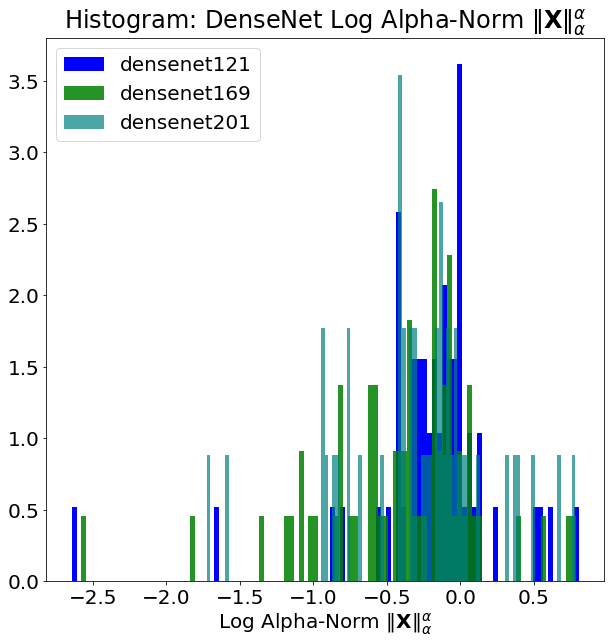

saving img/DenseNet_fnl_hist.png


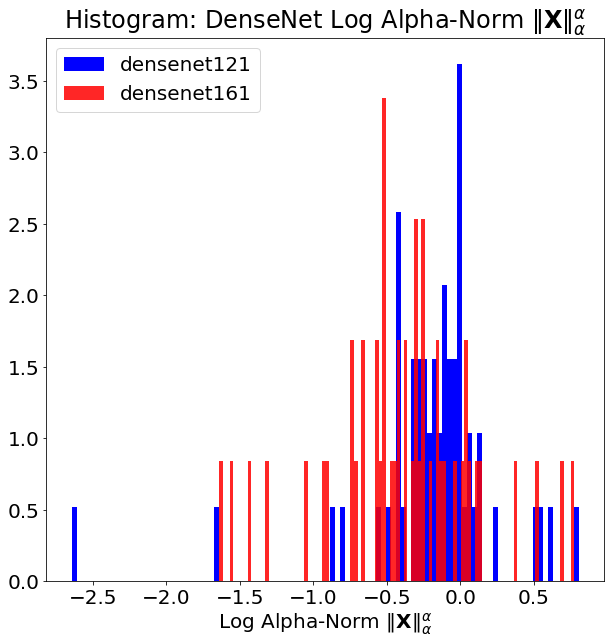

In [17]:
MP.plot_all_metric_histograms( \
    series_name, all_names, colors, all_summaries, all_details, \
    top1_errors, first_n_last_ids)

saving img/DenseNet_all_depth.png


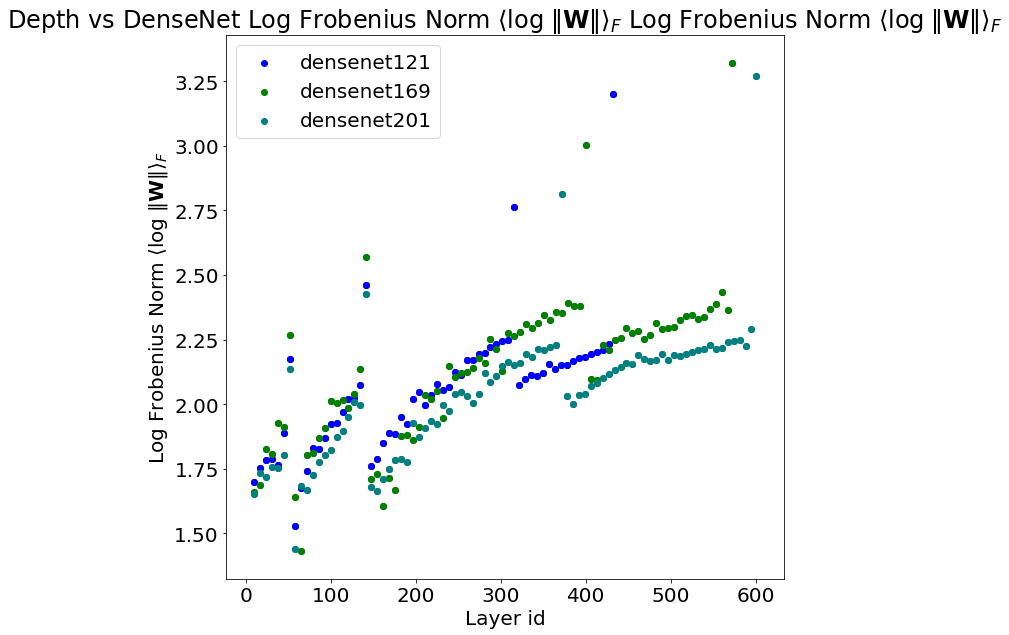

saving img/DenseNet_fnl_depth.png


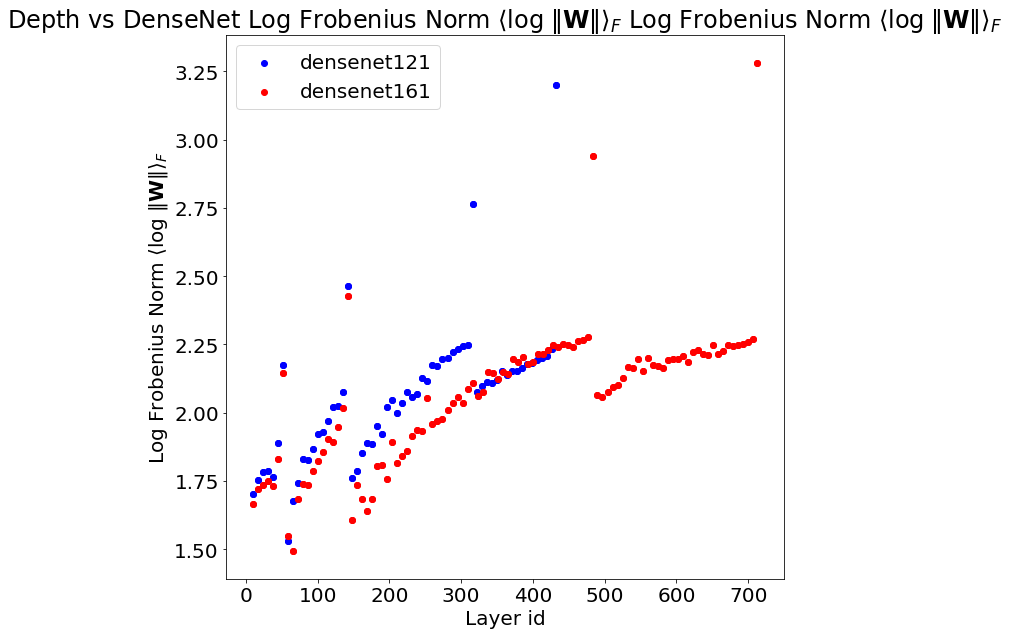

saving img/DenseNet_all_depth.png


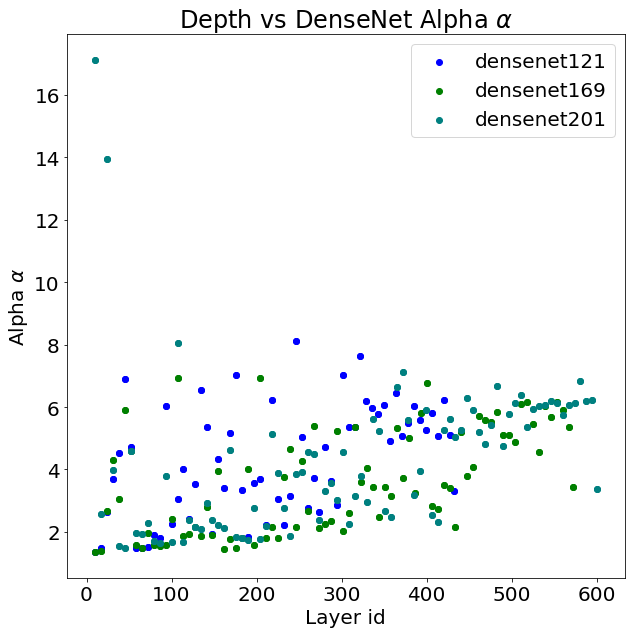

saving img/DenseNet_fnl_depth.png


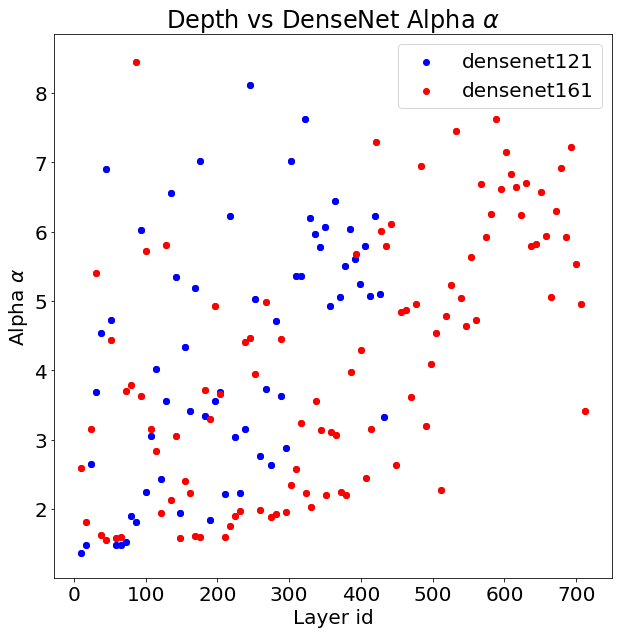

saving img/DenseNet_all_depth.png


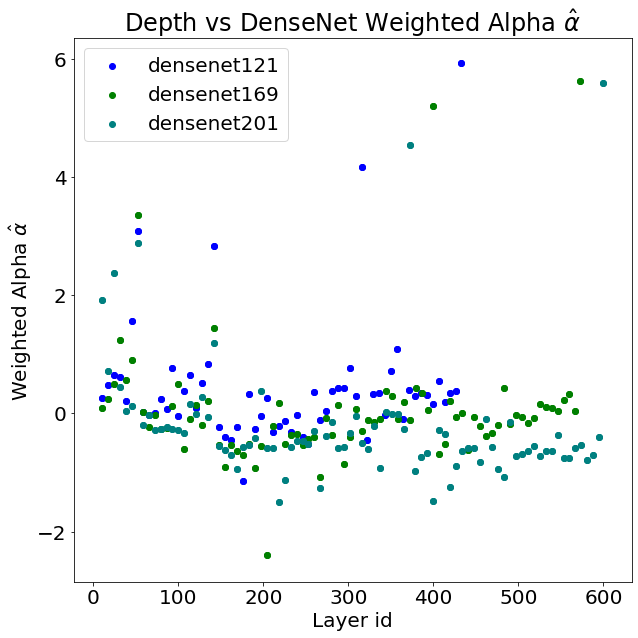

saving img/DenseNet_fnl_depth.png


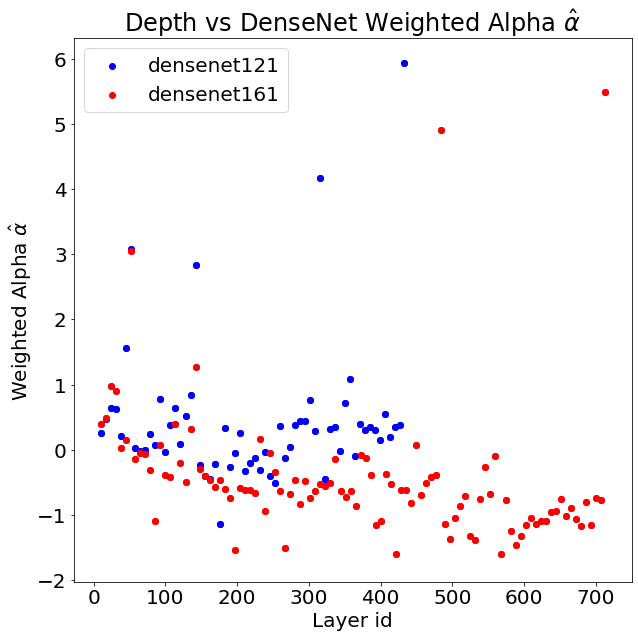

saving img/DenseNet_all_depth.png


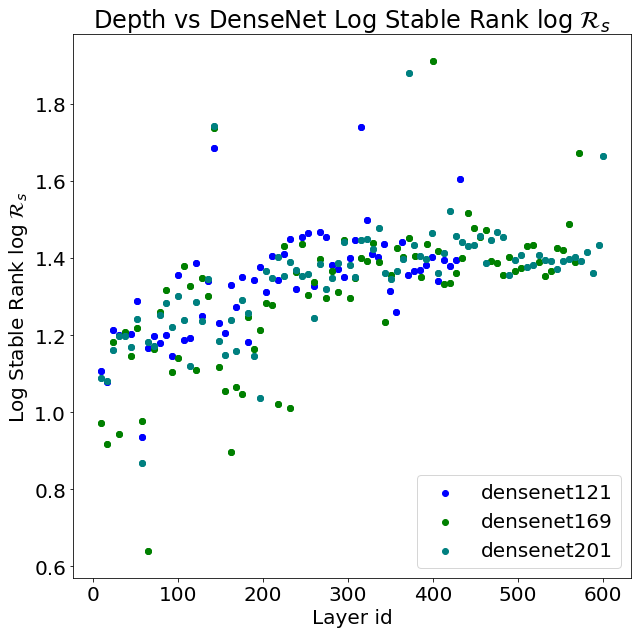

saving img/DenseNet_fnl_depth.png


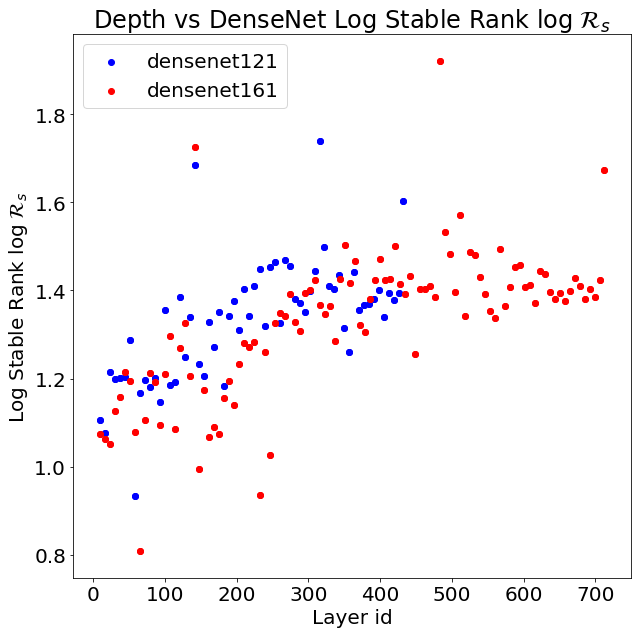

saving img/DenseNet_all_depth.png


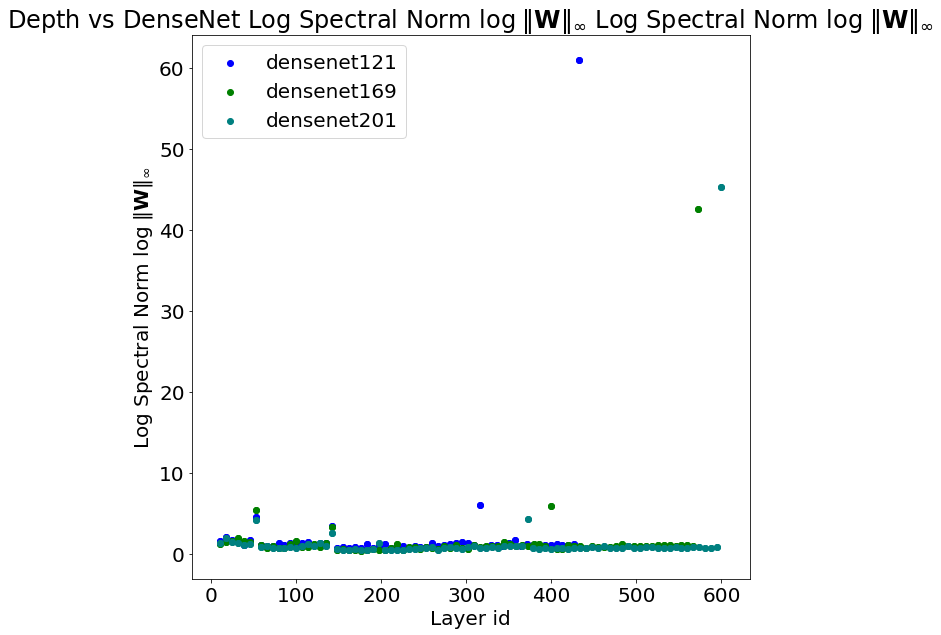

saving img/DenseNet_fnl_depth.png


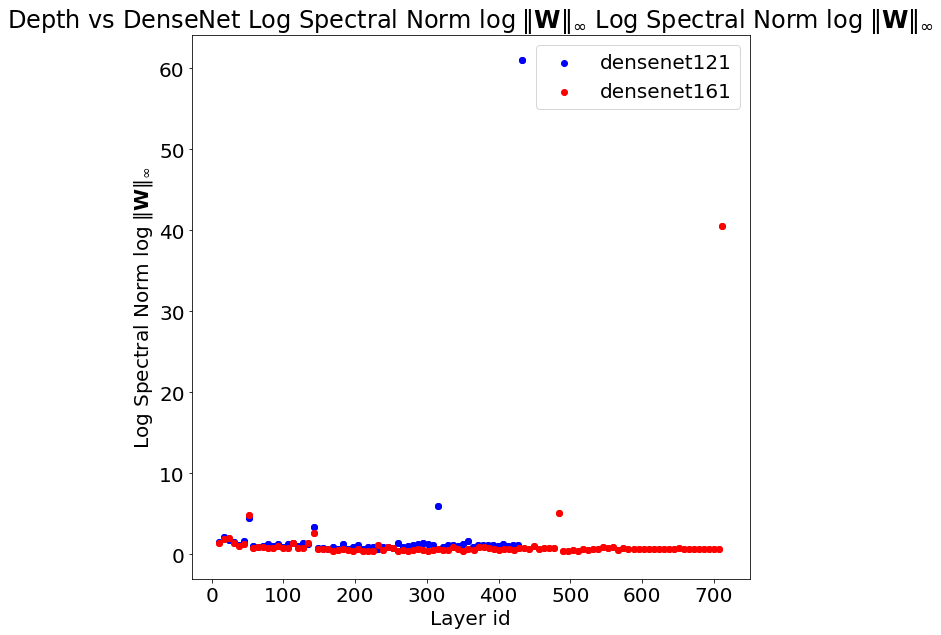

saving img/DenseNet_all_depth.png


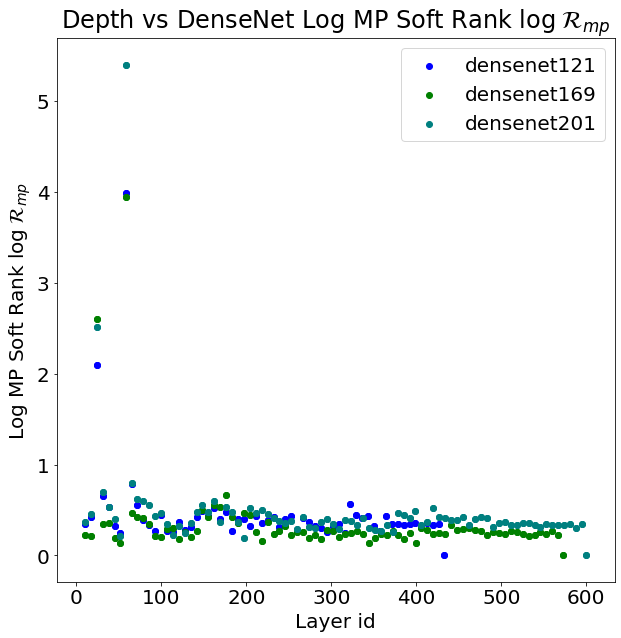

saving img/DenseNet_fnl_depth.png


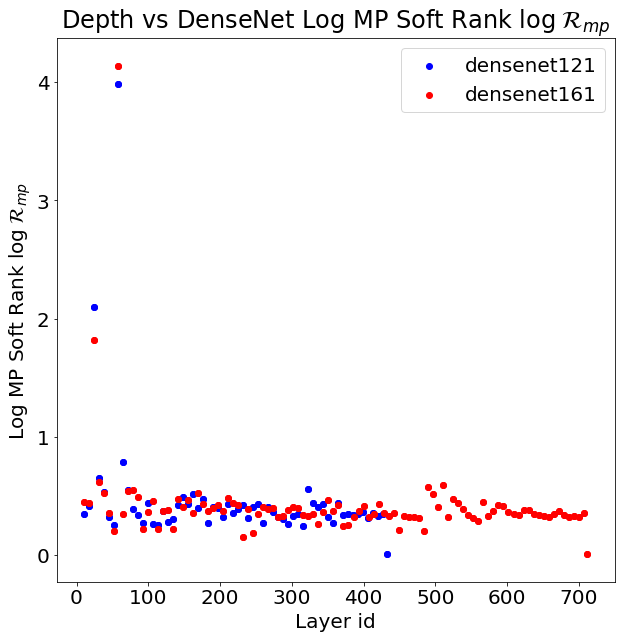

saving img/DenseNet_all_depth.png


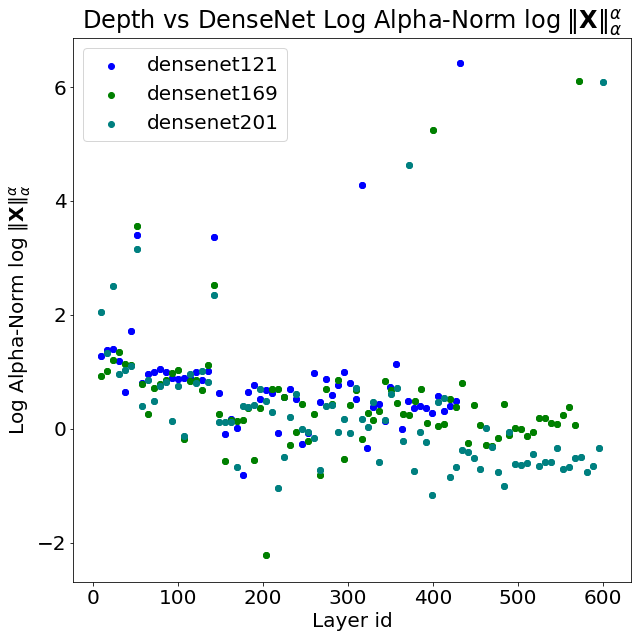

saving img/DenseNet_fnl_depth.png


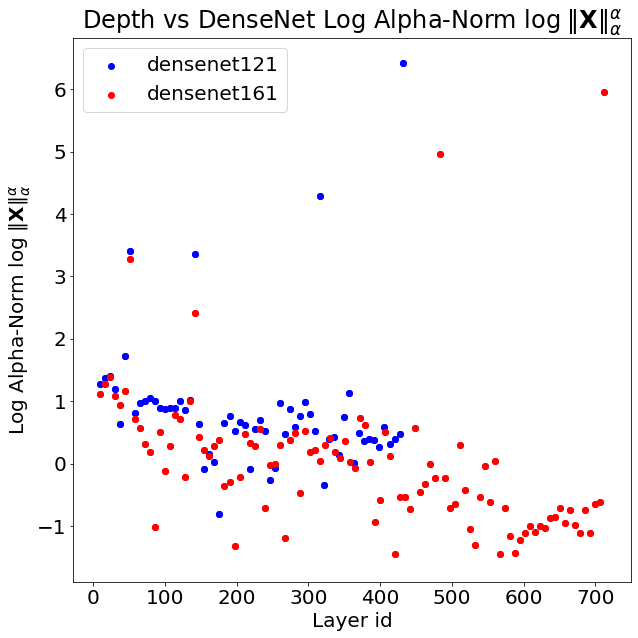

In [18]:
MP.plot_all_metric_vs_depth( \
    series_name, all_names, colors, all_summaries, all_details, \
    top1_errors, first_n_last_ids)
